# Project 1: Convolutional Neural Network for Fashion MNIST dataset
---

## Introduction
This report has been divided into three parts, each of which being subdivided into the seven steps of the design methodology we follow.

* **1. Goals**
* **2. Model and architecture of the CNN**
* **3. Data preparation**
* **4. Training procedures**
* **5. Test and performance evaluations**
* **6. Results, observations and conclusions**
* **7. Full code**

## 1. Goals
The aim of this project is the construction, analysis and documentation of a convolutional neural network for the classification of clothing images from the Fashion MNIST archive. The dataset is composed by 70,000 grayscale images with 28x28 pixel resolution. The dataset is also divided into a training set (60,000) and a test set (10,000 images).

## 2. Model and architecture of the CNN
The CNN is articulated into the following layers:
* *Convolutional 2D layer* with 20 filters of size 5x5; 
* *ReLU layer*, activation function;
* *Max pooling 2D layer* of size 2x2 and stride = 2;
* *Linear (fully connected) layer* with 10 nodes;
* *Softmax layer*, activation function.

![CNN Architecture](https://drive.google.com/uc?id=1EDQckhe9BXSLrlu-5DR9Pp1_dHXlrjCq)

## 3. Data Preparation

### Imports

We import all the useful modules.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

Then, we define some useful constants. We will train the network for 5 epochs, a learning rate of 0.001 and a batch size of 100. If the GPU is available use it for the computation otherwise use the CPU.

In [ ]:
# constants
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 100

# if available use GPU, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load the data

We load the Fashion MNIST dataset, and prepare the training set and test set. We will use the Pytorch module `torchvision.datasets`. It has many popular datasets like MNIST, FashionMNIST, CIFAR10 e.t.c.

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    root="./data", 
    download=True, 
    # convert image pixel data to tensors
    transform=transforms.Compose([transforms.ToTensor()])
    )
test_set = torchvision.datasets.FashionMNIST(
    root="./data", 
    download=True, 
    train=False, 
    # converting image pixel data to tensors
    transform=transforms.Compose([transforms.ToTensor()])
    )  

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE
    )

# check training set and test set size
print("Training set size:", len(train_set)) # 60000
print("Test set size:", len(test_set)) # 10000


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!
Training set size: 60000
Test set size: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize training data

Let's visualize 20 random images from the training set in a 4x5 grid.

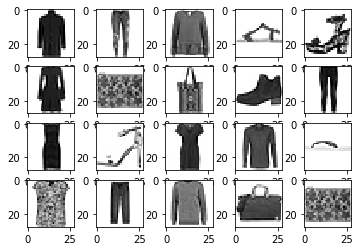

In [ ]:
import random

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data_len = example_data.shape[0] - 1

# create a list of 20 random numbers
randomlist = []
for i in range(0,20):
    n = random.randint(1,example_data_len)
    randomlist.append(n)

# visualize 20 random images
for i in range(len(randomlist)):
    plt.subplot(4, 5, i+1)
    plt.imshow(example_data[randomlist[i]][0], cmap='gray_r', interpolation='none')
plt.show()

## 4. Training procedures

### Network architecture

We define the CNN architecture. With the `print(model)` command we can visualize the network structure.

In [ ]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.conv2d = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fullyconn = nn.Linear(in_features=20*12*12, out_features=10)
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.conv2d(x)
        out = self.relu(out)
        out = self.maxpool2d(out)
        # reshape the tensor to a 1D vector for input to the fully connected layer
        out = out.view(out.size(0), -1) 
        out = self.fullyconn(out)
        out = self.softmax(out)
        
        return out
  
# Create a model
model = FashionCNN()
print(model)

FashionCNN(
  (conv2d): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fullyconn): Linear(in_features=2880, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


### Training

We transfer `model` into GPU if available. We define a Loss function, in our case `CrossEntropyLoss()`, and use Adam algorithm for optimization purpose.


We initialize some lists for storing loss and accuracy data, and execute the training by iterating over the epochs.

Last, we save the trained network to file.

In [ ]:
model.to(device)

# Loss function
error = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Counts the number of iterations
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []

for epoch in range(NUM_EPOCHS):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no 
        # mixing of gradient among the batches
        optimizer.zero_grad()
        
        # Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1

        #####################
        # Testing the model #
        #####################
    
        if not (count % 30): # It's same as "if count % 30 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
    print("Epoch: {}, Loss: {:.3f}, Accuracy: {:.2f}%".format(
        epoch+1, loss.data, accuracy
        )
    )

# Save the model
torch.save(model, "saved_FashionMNIST_CNN.pt")

Epoch: 1, Loss: 1.604, Accuracy: 83.00%
Epoch: 2, Loss: 1.610, Accuracy: 84.84%
Epoch: 3, Loss: 1.606, Accuracy: 85.33%
Epoch: 4, Loss: 1.592, Accuracy: 85.88%
Epoch: 5, Loss: 1.590, Accuracy: 86.24%


## 5. Test

### Loss and accuracy curves

Let's plot the loss and accuracy curves during training by using the data stored in `iteration_list`, `loss_list` and `accuracy_list`.

On the x-axis there is the number of iterations. Having a training set of 60 000 elements, a batch size of 100 and 5 epochs, the total number of iterations is 3000. 

$\text{number of batches} = \dfrac{\text{samples}}{\text{batch size}} = \dfrac{60000}{100} = 600$

$\text{number of iterations} = \text{epochs} \times \text{number of batches} = 5 \times 600 = 3000$

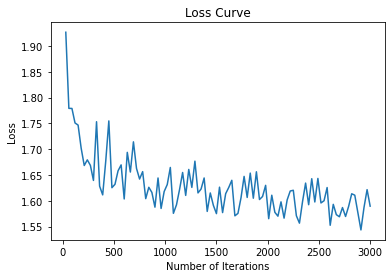

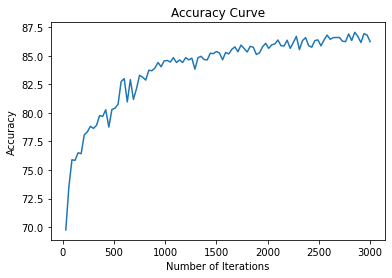

In [ ]:
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()


plt.plot(iteration_list, accuracy_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.show()

## 6. Results and conclusions

## 7. Code



---
## Bibliography

1. [Netron](https://netron.app/) - Visualizer for neural network, deep learning, and machine learning models.

2. [Fashion MNIST with PyTorch](https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy)

3. [MNIST Handwritten Digit Recognition in PyTorch](https://nextjournal.com/gkoehler/pytorch-mnist)